In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import tools

sc.logging.print_header()

os.chdir(os.path.expanduser('/home/jovyan/Zach/scanpy/'))
adata = sc.read_h5ad('h5ad/meninges_integrated.h5ad')
adata

scanpy==1.8.2 anndata==0.7.6 umap==0.5.1 numpy==1.21.6 scipy==1.5.2 pandas==1.3.5 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2 pynndescent==0.5.2


AnnData object with n_obs × n_vars = 10839 × 3266
    obs: 'sample_id', 'condition', 'site', 'sequencing_batch', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'S_score', 'G2M_score', 'phase', 'leiden', 'GSE23925_DARK_ZONE_VS_NAIVE_BCELL_DN', 'GSE23925_DARK_ZONE_VS_NAIVE_BCELL_UP', 'GSE23925_LIGHT_ZONE_VS_DARK_ZONE_BCELL_DN', 'GSE23925_LIGHT_ZONE_VS_DARK_ZONE_BCELL_UP', 'GSE23925_LIGHT_ZONE_VS_NAIVE_BCELL_DN', 'GSE23925_LIGHT_ZONE_VS_NAIVE_BCELL_UP', 'leiden_R', 'celltype', 'keep'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'condition_colors', 'filter_rna_colors', 'hvg', 'is_doublet_colors', 'keep_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'dist

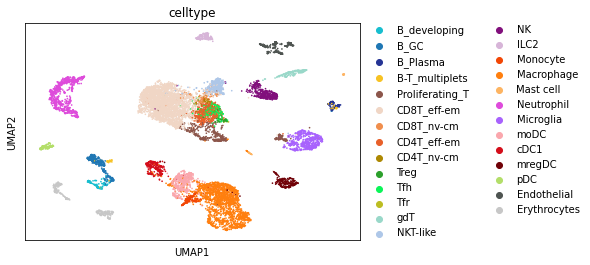

In [2]:
sc.pl.umap(adata, color = 'celltype')

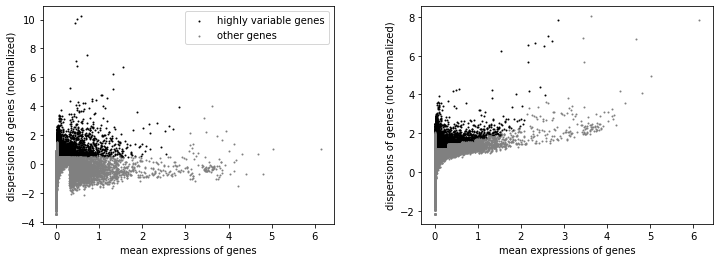

In [3]:
# re-compute umap for B cells
bdata = adata[adata.obs['celltype'].isin(['B-T_multiplets', 'B_GC', 'B_developing', 'B_Plasma'])].copy()
bdata = bdata.raw.to_adata()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bdata)

In [4]:
import re
for i in bdata.var.index:
    if re.search('^Igh', i):
        bdata.var.at[i, 'highly_variable'] = False

In [5]:
bdata.raw = bdata
bdata = bdata[:, bdata.var.highly_variable].copy()
bdata

AnnData object with n_obs × n_vars = 627 × 4159
    obs: 'sample_id', 'condition', 'site', 'sequencing_batch', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'S_score', 'G2M_score', 'phase', 'leiden', 'GSE23925_DARK_ZONE_VS_NAIVE_BCELL_DN', 'GSE23925_DARK_ZONE_VS_NAIVE_BCELL_UP', 'GSE23925_LIGHT_ZONE_VS_DARK_ZONE_BCELL_DN', 'GSE23925_LIGHT_ZONE_VS_DARK_ZONE_BCELL_UP', 'GSE23925_LIGHT_ZONE_VS_NAIVE_BCELL_DN', 'GSE23925_LIGHT_ZONE_VS_NAIVE_BCELL_UP', 'leiden_R', 'celltype', 'keep'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'condition_colors', 'filter_rna_colors', 'hvg', 'is_doublet_colors', 'keep_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [6]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
# sc.pp.regress_out(bdata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(bdata, max_value=10)

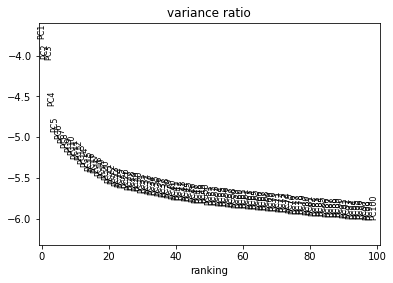

In [7]:
sc.tl.pca(bdata, svd_solver='arpack', n_comps=100)
sc.pl.pca_variance_ratio(bdata, log=True, n_pcs=100)

In [8]:
sc.external.pp.harmony_integrate(bdata, key = 'sequencing_batch', adjusted_basis='X_pca', max_iter_harmony = 30)

2022-08-01 10:26:14,051 - harmonypy - INFO - Iteration 1 of 30
2022-08-01 10:26:14,454 - harmonypy - INFO - Iteration 2 of 30
2022-08-01 10:26:14,854 - harmonypy - INFO - Iteration 3 of 30
2022-08-01 10:26:15,254 - harmonypy - INFO - Iteration 4 of 30
2022-08-01 10:26:15,558 - harmonypy - INFO - Iteration 5 of 30
2022-08-01 10:26:15,854 - harmonypy - INFO - Iteration 6 of 30
2022-08-01 10:26:16,063 - harmonypy - INFO - Iteration 7 of 30
2022-08-01 10:26:16,378 - harmonypy - INFO - Converged after 7 iterations


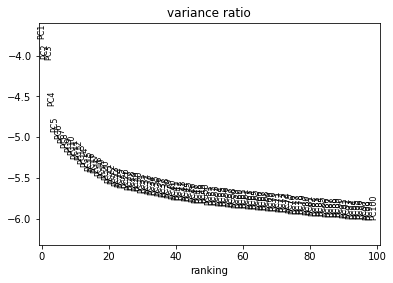

In [9]:
sc.pl.pca_variance_ratio(bdata, log=True, n_pcs=100)

In [10]:
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs = 60)
sc.tl.umap(bdata, min_dist=.3)

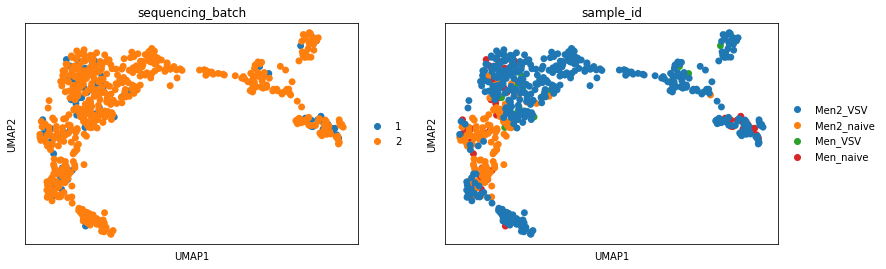

In [11]:
sc.pl.umap(bdata, color=['sequencing_batch', 'sample_id'])

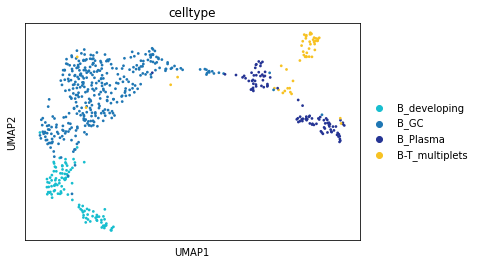

In [12]:
sc.pl.umap(bdata, color=['celltype'], size = 30)

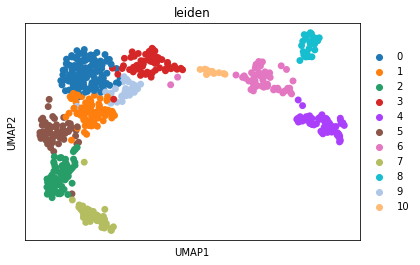

In [13]:
sc.tl.leiden(bdata)
sc.pl.umap(bdata, color = 'leiden')

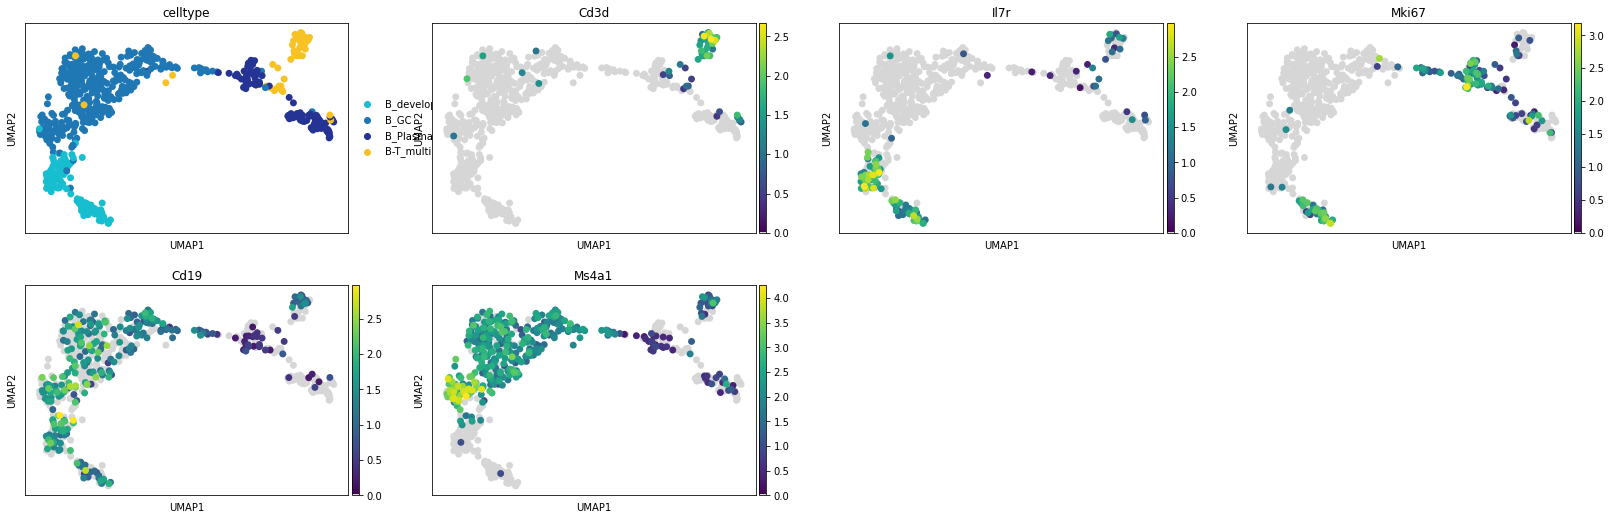

In [14]:
sc.pl.umap(bdata, color=['celltype', 'Cd3d', 'Il7r', 'Mki67', 'Cd19', 'Ms4a1'], color_map = tools.cmp())

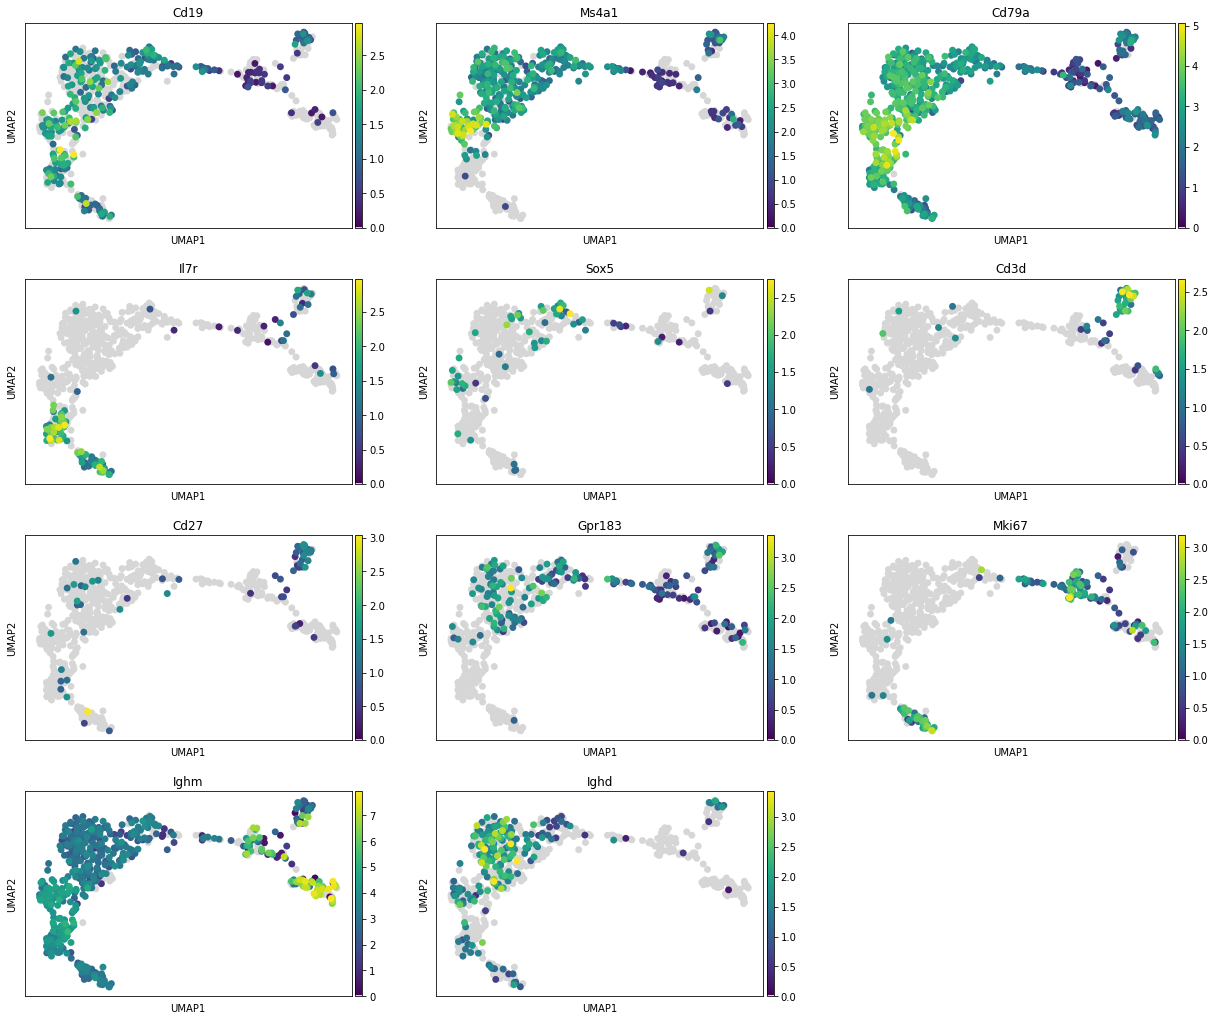

In [15]:
sc.pl.umap(bdata, color = ['Cd19', 'Ms4a1', 'Cd79a', 'Il7r', 'Sox5', 'Cd3d', 'Cd27', 'Gpr183', 'Mki67', 'Ighm', 'Ighd'], color_map = tools.cmp(), ncols = 3)

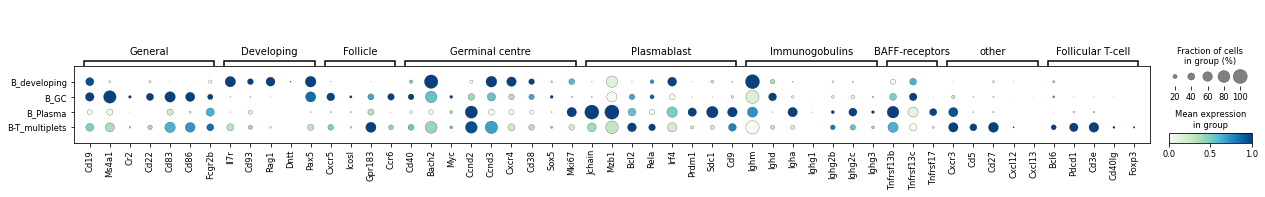

In [16]:
sc.pl.dotplot(bdata, 
              {'General':[ 'Cd19', 'Ms4a1',  'Cr2', 'Cd22', 'Cd83', 'Cd86', 'Fcgr2b'],
               'Developing':['Il7r', 'Cd93', 'Rag1', 'Dntt', 'Pax5'],
               'Follicle':['Cxcr5', 'Icosl', 'Gpr183', 'Ccr6'],
               'Germinal centre':['Cd40', 'Bach2', 'Myc', 'Ccnd2', 'Ccnd3', 'Cxcr4', 'Cd38', 'Sox5', 'Mki67',],
               'Plasmablast':['Jchain','Mzb1', 'Bcl2', 'Rela', 'Irf4', 'Prdm1', 'Sdc1', 'Cd9',],
               'Immunogobulins':['Ighm', 'Ighd', 'Igha', 'Ighg1','Ighg2b','Ighg2c', 'Ighg3'],
               'BAFF-receptors':['Tnfrsf13b', 'Tnfrsf13c', 'Tnfrsf17'],
               'other':['Cxcr3', 'Cd5', 'Cd27', 'Cxcl12', 'Cxcl13'],
               'Follicular T-cell':['Bcl6', 'Pdcd1', 'Cd3e', 'Cd40lg', 'Foxp3'],
              }
              , groupby = 'celltype', color_map = 'GnBu', standard_scale = 'var', var_group_rotation = 0)

In [17]:
# save
bdata.write_h5ad('h5ad/meninges_integrated_b_cells.h5ad', compression = 'gzip')